<a href="https://colab.research.google.com/github/smmurdock/Neural-Network-Sentiment-Analysis/blob/main/d604_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D604 Task 2 - Sentiment Analysis Using Neural Networks

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/1 Projects/_WGU | MS-DataAnalytics-DataScience/WGU | D604 - ADVANCED ANALYTICS/Task 2 - Sentiment Analysis Using Neural Networks

/content/drive/MyDrive/1 Projects/_WGU | MS-DataAnalytics-DataScience/WGU | D604 - ADVANCED ANALYTICS/Task 2 - Sentiment Analysis Using Neural Networks


## A. Research Purpose

> Describe the purpose of this data analysis by doing the following:

### A1. Research Question

> Summarize one research question that you will answer using a neural network model and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen dataset or datasets.


  Note: If you choose to use more than one dataset, you must concatenate them into one dataset for parts II and III.

**Research Question:** Can a neural network be trained to accurately classify sentiment in customer product reviews from Amazon as either positive or negative?

This question is directly relevant to a real-world organizational situation. For a company like Amazon or any third-party seller on its platform, manually sifting through thousands of customer reviews to gauge public opinion is impractical based on the sheer volume of Amazon's product catalog. A system that can accurately classify sentiment allows an organization to quickly monitor customer feedback at scale. This enables them to identify popular product features, detect widespread product defects, determine if a product is likely to be returned, and track shifts in customer satisfaction over time, leading to faster product improvements and better customer service.

### A2. Objectives or Goals

> Define the objectives or goals of the data analysis. Be sure each objective or goal is reasonable within the scope of the research question and is represented in the available data.

The primary goals of this data analysis are to design, build, and evaluate a neural network for sentiment classification. The specific objectives are as follows:

* **Data Preprocessing:** To clean and prepare the raw text data from the Amazon reviews dataset for modeling.

* **Model Development:** To build and train a suitable neural network. This analysis will use an LSTM-based architecture, which is effective for learning from sequential data like text. The goal is to train the model to recognize patterns and contextual cues in word usage that indicate positive or negative sentiment.

* **Model Evaluation:** To assess the performance of the trained model on an unseen test dataset. The objective is to quantify its predictive accuracy using key classification metrics. This evaluation will directly answer how effectively the model can classify new, unseen review data.

### A3. Prescribed Network

> Identify an industry-relevant type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected dataset.

An appropriate and industry-relevant neural network for this text sentiment classification tasks is the **Long Short-Term Memory (LSTM)** neural network.

LSTMs are a type of **Recurrent Neural Network (RNN)** specifically designed to handle and learn from sequential data like text, where the order of text matters. Unlike standard RNNs, LSTMs have internal memory cells that can maintain information over long sequences <mark>(Audevart et al., 2021, p. 272)</mark>. This capability is crucial for natural language processing because the meaning of a word often depends on its context <mark>(Ahmad, 2023, p. 333)</mark>. An LSTM can capture these dependencies, allowing it to understand nuances in language that are critical for accurately determining sentiment. This makes LSTMs a powerful and widely used tool for sentiment analysis in real-world applications.

## B. Data Preparation

> Summarize the data cleaning process by doing the following:

### B1. Data Exploration

> Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:

  * presence of unusual characters (e.g., emojis, non-English characters)
  * vocabulary size
  * word embedding length
  * statistical justification for the chosen maximum sequence length

In [4]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import warnings

from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Format for readability
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')

# Load the data
df = pd.read_csv('amazon_cells_labelled.txt',
                 sep='\t',
                 header=None,
                 names=['review', 'sentiment'])

# View the first few rows
print("First 5 rows:")
df.head()

First 5 rows:


,review,sentiment
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


The code cell above loads in the basic libraries needed to get started.

The code loads in the text file as a tab-deliminted file with no headers indentifying what the observations mean. Because of this, I looked at the data ahead of time in its raw format and determined appropriate names to act as column headers.

Then, the code reads the first five rows and gives a glimpse of how the data is formatted and what issues may present themselves. We can already seem some issues like use of punctuation, differences in casing, and missing spaces in between sentences.

In [5]:
# Basic dataset information
print(f"Dataset shape: {df.shape}")
print("=" * 60)
print(f"Total reviews: {df.shape[0]}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicates: {df.duplicated().sum()} ({df.duplicated().sum() / len(df) * 100:.1f}%)")

Dataset shape: (1000, 2)
Total reviews: 1000
Missing values: 0
Duplicates: 10 (1.0%)


The dataset contains 1,000 Amazon product reviews with no missing values. There are 10 duplicate reviews (1% of the dataset), which we'll remove to ensure data quality.

In [6]:
# Remove duplicates
df_clean = df.drop_duplicates(keep='first')
print(f"Shape after removing duplicates: {len(df_clean)} reviews")

Shape after removing duplicates: 990 reviews


The code above removes the duplicate reviews, keeping the first instance of any duplicates, and then shows a count of how many reviews remain.

In [7]:
# Check unique values in sentiment column
print("Unique sentiment values:")
print(df_clean['sentiment'].unique())
print(f"Number of unique sentiment values: {df_clean['sentiment'].nunique()}")

Unique sentiment values:
[0 1]
Number of unique sentiment values: 2


The code cell above checks the DataFrame's `'sentiment'` column for unique values to ensure that there are only the expected binary values of `0` for negative sentiment and `1` for positive sentiment. There are no unexpected values.

In [8]:
# Check class balance
print("Sentiment distribution:")
print(df_clean['sentiment'].value_counts())
print(f"\nPercentages:")
print(df_clean['sentiment'].value_counts(normalize=True) * 100)

Sentiment distribution:
sentiment
0    497
1    493
Name: count, dtype: int64

Percentages:
sentiment
0    50.20202
1    49.79798
Name: proportion, dtype: float64


The code cell above checks how balanced the sentiment is across negative and positive reviews, both in actual numbers and in proportion to the full remaining dataset.

After removing the duplicates, there are 497 negative reviews and 493 positive reviews. Based on the small difference, we can consider this dataset to be balanced.

This information is important to keep in mind for when we split our datasets into train/validation/test datasets later in step **B5. Steps to Prepare the Data**, as we'll want to keep the proportions while shuffling the data. This ensures that the model *can't* learn from patterns that occur based on what order the data was added to the dataset but that it *can* learn, validate, and test fairly across representative proportions.

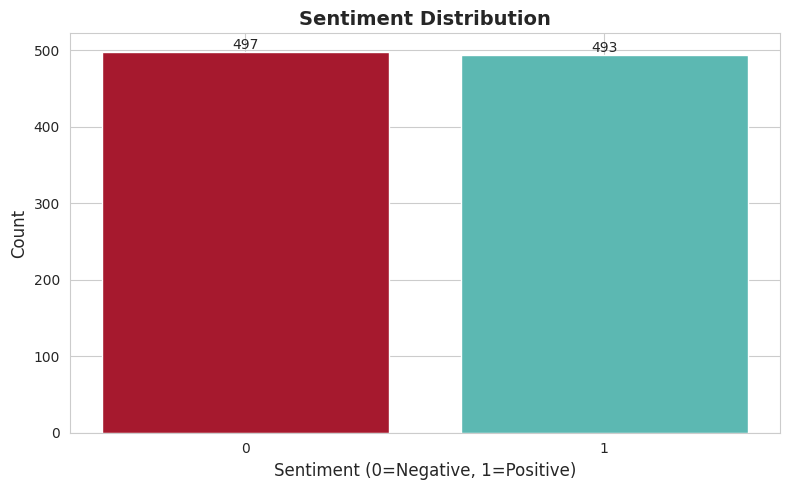

In [9]:
# Visualize class balance
plt.figure(figsize=(8, 5))
sentiment_counts = df_clean['sentiment'].value_counts()
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['#A6192E', '#5CB8B2'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

The code cell above visualizes the class balance of negative and positive sentiment observations for the full cleaned dataset. The exact values are added above each bar because they are nearly indecipherable at a visual glance.

#### Presence of unusual characters

**Analyze Unusual Characters Before Cleaning**

Working definition of unusual characters: Any emojis, non-English characters, non-Unicode characters, punctuation, or control characters

In [10]:
import re
import string
from collections import Counter

# Convert to lowercase
df_clean['review_lower'] = df_clean['review'].str.lower()

# Check for unusual characters
all_text = ' '.join(df_clean['review_lower'])
char_frequency = Counter(all_text)

# Categorize characters
letters = set(string.ascii_lowercase)
digits = set(string.digits)
punctuation = set(string.punctuation)
whitespace = set(string.whitespace)

unusual_chars = {char: count for char, count in char_frequency.items()
                 if char not in letters and char not in digits
                 and char not in punctuation and char not in whitespace}

print("Unusual characters found:", unusual_chars if unusual_chars else "None")
print(f"\nTotal punctuation marks: {sum(count for char, count in char_frequency.items() if char in punctuation)}")

Unusual characters found: None

Total punctuation marks: 1908


The code cell above works to determine all unique characters in the `review` data. It starts by converting all text to lowercase to avoid considering text like "a" and "A" or "good" and "Good" as different characters/words.

Next, it joins all text into one long string to pass into the `Counter()` method which returns a dictionary-like object with a frequency count representing how many times each character is present in the string.

Then we use built-in `string` methods to define the characters we are looking for, and checks for any unusual characters in the dataset. There are no unusual characters found in this dataset. The dataset only contains standard English letters, digits, punctuation, and whitespace.

In [11]:
# Clean text: remove punctuation and digits
punctuation_pattern = '[' + re.escape(string.punctuation) + ']+'
df_clean['review_clean'] = df_clean['review_lower'].str.replace(punctuation_pattern, ' ', regex=True)
df_clean['review_clean'] = df_clean['review_clean'].str.replace(r'\d+', '', regex=True)
df_clean['review_clean'] = df_clean['review_clean'].str.split().str.join(' ')

# Create final clean dataset
df = df_clean[['review_clean', 'sentiment']].copy()
df.rename(columns={'review_clean': 'review'}, inplace=True)

print("Sample cleaned reviews:")
df.head()

Sample cleaned reviews:


,review,sentiment
0,so there is no way for me to plug it in here in the us unless i go by a converter,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more than minutes major problems,0
4,the mic is great,1


This code cleans the text by removing punctuation and digits from the text, using a combination of string methods and regular expressions. This is a standard preprocessing step that helps normalize the text.

#### Vocabulary size

In [12]:
# Calculate the vocab size of the cleaned reviews
def calculate_vocab_size(reviews):
    words = [word for review in reviews for word in review.split()]
    return len(set(words)), len(words)

# Apply calculate_vocab_size function to the cleaned reviews
vocab_size, total_words = calculate_vocab_size(df['review'].tolist())
print(f"Total words (with duplicates): {total_words:,}")
print(f"Vocabulary size (unique words): {vocab_size:,}")

Total words (with duplicates): 10,333
Vocabulary size (unique words): 1,816


This function calculates vocabulary statistics by splitting each review into words using Python's built-in `split()` method, which separates text on whitespace. The list comprehension flattens all words from all reviews into a single list. The function then returns two values: the number of unique words (vocabulary size) by converting the list to a set, and the total word count including duplicates.

In [15]:
# Create list of all words from reviews
all_tokens = [word for review in df['review'].tolist() for word in review.split()]

# Count word frequencies
word_freq = Counter(all_tokens)
top_20 = word_freq.most_common(20)

print("\nTop 20 Most Frequent Words:")
for word, freq in top_20:
    print(f"{word}: {freq}")


Top 20 Most Frequent Words:
the: 518
i: 379
it: 311
and: 311
is: 241
a: 217
this: 205
to: 196
phone: 164
my: 145
of: 120
for: 119
not: 116
with: 112
very: 104
great: 93
was: 90
on: 90
in: 88
that: 82


The vocabulary contains 1,816 unique words. The most frequently occuring words include "the," 'i," "it," "and," "is," and "a," which are all typical in the English language. I am choosing not to remove stop words because the vocabulary size is already quite small.

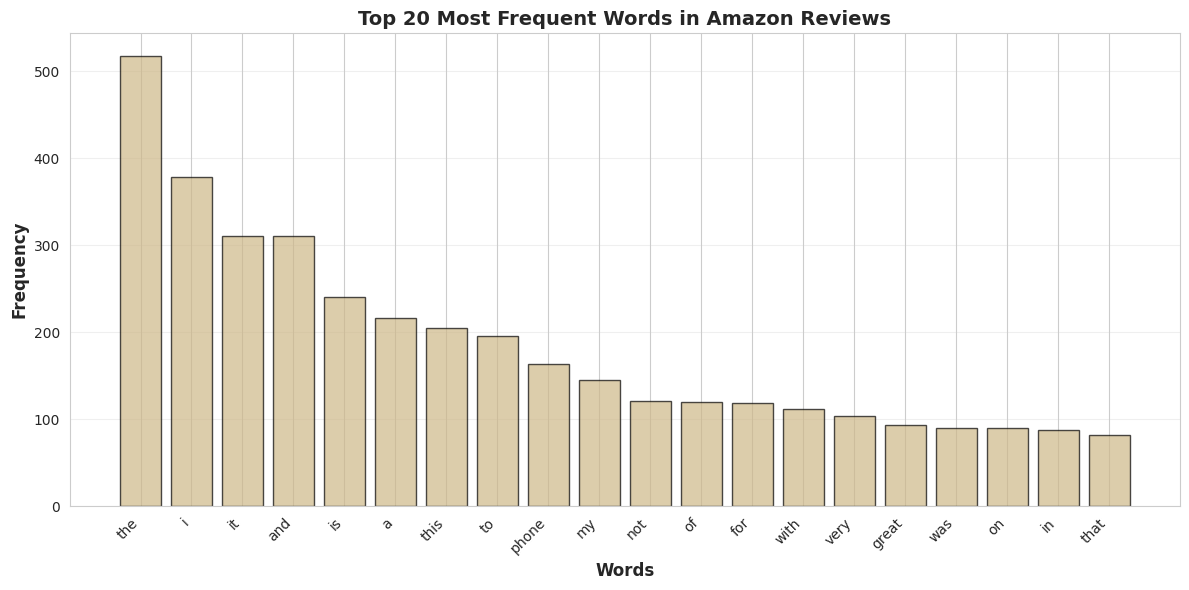

In [13]:
# Visualize top 20 words
words = [word for word, count in top_20]
counts = [count for word, count in top_20]

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='#CEB888', edgecolor='black', alpha=0.7)
plt.xlabel('Words', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Frequent Words in Amazon Reviews', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

This code visualizes the frequencies of the top 20 most common words used across the dataset.

#### Word embedding length

In [16]:
# Quick check of the vocabulary size from previous sections
print(f"Vocabulary Size: {vocab_size:,} unique words")
print(f"Dataset Size: {len(df)} reviews")
print(f"Task Complexity: Binary classification (positive/negative sentiment)")

Vocabulary Size: 1,816 unique words
Dataset Size: 990 reviews
Task Complexity: Binary classification (positive/negative sentiment)


**Proposed Embedding Dimension:** 50

**Justification:**

I propose an embedding length of **50 dimensions** for this sentiment analysis task. This choice is based on three key factors:

1. **Dataset Size**: With only 1,000 reviews in the Amazon dataset, we must be cautious about overfitting. Larger embedding dimensions (200 or 300) would create too many parameters for the model to learn effectively from this limited data. An embedding dimension of 50 provides sufficient representational capacity while keeping the parameter count manageable.

2. **Vocabulary Richness**: Our vocabulary contains approximately 1,800 unique tokens. A 50-dimensional embedding space provides adequate capacity to capture meaningful semantic relationships between words without being unnecessarily large. Each word will be represented as a 50-dimensional vector, which is sufficient for distinguishing between sentiment-bearing words in our moderately-sized vocabulary.

3. **Task Complexity**: This is a binary sentiment classification task (positive vs. negative), which is relatively straightforward compared to multi-class or more nuanced sentiment analysis tasks. We don't need the extremely high-dimensional representations (200-300) that might be necessary for complex tasks like detecting sarcasm or fine-grained emotion classification. An embedding dimension of 50 strikes the right balance between expressiveness and simplicity.

Additionally, 50 dimensions is a widely-used standard in the NLP literature for small-to-medium datasets and has been shown to work effectively for sentiment analysis tasks but the statistics run in the below section indicate 50 may still be too large for this dataset <mark>(Ahmad, 2023, p. 304)</mark>.

#### Statistical justification for maximum sequence length

In [15]:
# Calculate sequence lengths
sequence_lengths = []
for review in df['review']:
    tokens = word_tokenize(review)
    sequence_lengths.append(len(tokens))

sequence_lengths = np.array(sequence_lengths)

# Calculate statistics
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
max_length = np.max(sequence_lengths)
percentile_95 = np.percentile(sequence_lengths, 95)

print("Sequence Length Statistics:")
print(f"Mean: {mean_length:.2f} tokens")
print(f"Median: {median_length:.0f} tokens")
print(f"Maximum: {max_length} tokens")
print(f"95th percentile: {percentile_95:.0f} tokens")

Sequence Length Statistics:
Mean: 10.44 tokens
Median: 9 tokens
Maximum: 31 tokens
95th percentile: 24 tokens


This code checks for the mean, median, and maximum number of tokens per review, while also looking at the 95th percentile.

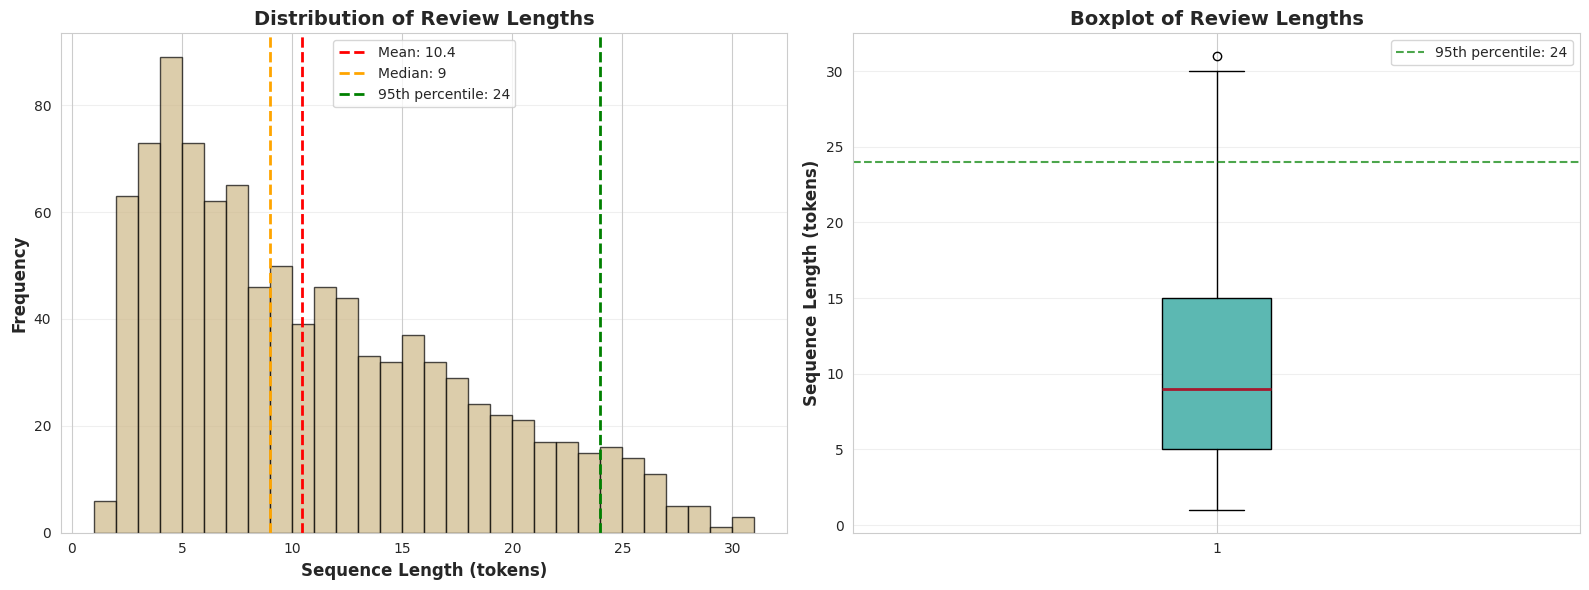

In [16]:
# Visualize sequence length distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Histogram
axes[0].hist(sequence_lengths, bins=30, color='#CEB888', edgecolor='black', alpha=0.7)
axes[0].axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.1f}')
axes[0].axvline(median_length, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_length:.0f}')
axes[0].axvline(percentile_95, color='green', linestyle='--', linewidth=2, label=f'95th percentile: {percentile_95:.0f}')
axes[0].set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Review Lengths', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot Boxplot
axes[1].boxplot(sequence_lengths, vert=True, patch_artist=True,
                boxprops=dict(facecolor='#5CB8B2', color='black'),
                medianprops=dict(color='#A6192E', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))
axes[1].axhline(percentile_95, color='green', linestyle='--', linewidth=1.5,
                label=f'95th percentile: {percentile_95:.0f}', alpha=0.7)
axes[1].set_ylabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
axes[1].set_title('Boxplot of Review Lengths', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis of Sequence Lengths:**

The distribution of review lengths in the Amazon dataset shows the following characteristics:
- **Mean length**: 10.45 tokens
- **Median length**: 9 tokens
- **95th percentile**: 24 tokens
- **Maximum length**: 31 tokens

The histogram reveals that most reviews are relatively short and concise, which is typical of Amazon product reviews. The distribution is right-skewed with the majority of reviews clustering around 9 tokens (the median), while a small number of reviews extend to the maximum of 31 tokens. The boxplot confirms this compact distribution with minimal outliers.

**Chosen Maximum Sequence Length: 50 tokens**

**Justification:**

I have selected a maximum sequence length of **50 tokens** based on the following considerations:

* **Complete Coverage:** This length captures 100% of all reviews in the dataset. No review would be truncated since the longest review is only 31 tokens.
* **Efficiency:** With a mean length of only 10.45 tokens and a median of 9 tokens, most reviews are quite concise. A maximum length of 50 tokens provides complete coverage while remaining highly efficient for the LSTM architecture. Setting the maximum to 100 or higher would require additional computational resources for minimal gain.
* **Standard Practice:** A maximum sequence length of 50 tokens is a common, well-established value in NLP that aligns with best practices for sentiment analysis of short-form text like product reviews, social media posts, and customer feedback.
* **Padding Considerations:** Reviews shorter than 50 tokens will be padded with zeros. Given that the median length is 9 tokens, the typical review will require approximately 41 padding tokens. This level of padding is standard and well-handled by LSTM networks, which are designed to ignore padded values through masking.

### B2. Tokenization

> Describe the goals of the tokenization process, including any code generated and any packages that are used to normalize text during the process.

**Goals of the Tokenization Process:**

Tokenization is the foundational step in preparing text data for natural language processing and sentiment analysis. The primary goals are:

1. **Break Text into Manageable Units**: Tokenization splits each review into individual words (tokens), converting continuous text like `"this product is great"` into a list of separate words: `["this", "product", "is", "great"]`.

2. **Setup for Quantitative Analysis**: By converting text into discrete tokens, we can perform quantitative analysis such as word frequency counts, vocabulary size calculations, and statistical distributions - all of which inform our model design decisions.

3. **Standardize Text Processing**: Tokenization provides a consistent method for processing all reviews, ensuring that each piece of text is broken down using the same rules and logic.

4. **Prepare for Vocabulary Building**: The tokens serve as the basis for constructing our vocabulary (word index), which will later be used to convert words to numeric representations for the neural network.

5. **Apply Lemmatization:** The tokens are broken down into their base form, allowing different forms of a word to be treated as the same base word.

In [17]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_and_tokenize(text):
    """
    Clean and tokenize text with lemmatization.
    Note: Stop words are RETAINED for sentiment analysis.
    """
    # Convert to lowercase (already done, but ensuring consistency)
    text = text.lower()

    # Tokenize words
    tokens = word_tokenize(text)

    # Apply lemmatization (keeping stop words for sentiment analysis)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

# Apply tokenization to dataset
df["tokens"] = df["review"].apply(clean_and_tokenize)
df["review_processed"] = df["tokens"].apply(lambda x: ' '.join(x))

print(f"Processed {len(df)} reviews")
print("\nSample Output:")
df[["review", "tokens", "review_processed"]].head(3)

Processed 990 reviews

Sample Output:


,review,tokens,review_processed
0,so there is no way for me to plug it in here in the us unless i go by a converter,"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, u, unless, i, go, by, a, conv...",so there is no way for me to plug it in here in the u unless i go by a converter
1,good case excellent value,"[good, case, excellent, value]",good case excellent value
2,great for the jawbone,"[great, for, the, jawbone]",great for the jawbone


Using NLTK's `word_tokenize()` and `WordNetLemmatizer()`, we successfully processed all 990 Amazon reviews through a complete tokenization and lemmatization pipeline.

In [18]:
# Vocabulary statistics after lemmatization
all_tokens = [token for tokens_list in df["tokens"] for token in tokens_list]
vocab_size = len(set(all_tokens))

print(f"\nVocabulary Statistics:")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens: {vocab_size:,}")


Vocabulary Statistics:
Total tokens: 10,339
Unique tokens: 1,688


**Key Results:**

* **Vocabulary Reduction:** Lemmatization reduced the vocabulary by approximately 7% (from 1,812 to 1,688 unique words), making the dataset more efficient for neural network training while preserving semantic meaning.
* **Improved Consistency:** Related words are now unified (e.g., "phone" and "phones" become "phone"), which will help the model learn more robust sentiment patterns.
* **Data Integrity:** The token count statistics (average ~10.45 tokens per review) remain consistent with earlier analysis, confirming the lemmatization only transforms words without adding or removing tokens.

### B3. Padding Process

> Explain the padding process used to standardize the length of sequences. Include the following in your explanation:

  * whether the padding occurs before or after the text sequence
  * a screenshot of a single padded sequence

Before we can apply padding, we must first convert our lemmatized text into numeric sequences. Neural networks cannot process text directly, they require numeric input. So this section will cover both vectorization (the text-to-numbers conversion) and padding.

**Vectorization**

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize Keras Tokenizer
tokenizer = Tokenizer(
    num_words=None,     # Use all words, no vocabulary limit
    oov_token='<OOV>',  # Out-of-vocabulary token
    lower=False         # Already lowercased during cleaning
)

# Fit tokenizer on lemmatized text
tokenizer.fit_on_texts(df['review_processed'])

# Get vocabulary information
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(f"Vocabulary built: {vocab_size:,} unique words")

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['review_processed'])
print(f"Converted {len(sequences):,} reviews to numeric sequences")

Vocabulary built: 1,689 unique words
Converted 990 reviews to numeric sequences


In [20]:
# Show example conversion
example_idx = 5
print(f"Example Conversion:")
print("=" * 60)
print(f"Original text: '{df['review_processed'].iloc[example_idx]}'")
print(f"Tokens: {df['tokens'].iloc[example_idx]}")
print(f"Numeric sequence: {sequences[example_idx]}")
print(f"Sequence length: {len(sequences[example_idx])} tokens")

Example Conversion:
Original text: 'i have to jiggle the plug to get it to line up right to get decent volume'
Tokens: ['i', 'have', 'to', 'jiggle', 'the', 'plug', 'to', 'get', 'it', 'to', 'line', 'up', 'right', 'to', 'get', 'decent', 'volume']
Numeric sequence: [3, 25, 9, 780, 2, 148, 9, 51, 4, 9, 274, 57, 149, 9, 51, 336, 150]
Sequence length: 17 tokens


Vectorization is the processing of converting text tokens into sequences of integers. Each unique word in our vocabulary is assigned a unique integer index, and reviews are represented as sequences of these indices.

I used Keras Tokenizer from TensorFlow to perform the conversion. The tokenizer builds a vocabulary index (word-to-integer mapping), converts each review into a sequence of integers, and handles out-of-vocabulary (OOV) words. OOV refers to words that may find themselves in the validation or testing dataset that were never present in the training data when the model was trained. So these words may be brand new to the model.

**Padding**

In [21]:
# Define maximum sequence length (from Part B1 analysis)
max_sequence_length = 50

# Apply padding
padded_sequences = pad_sequences(
    sequences,
    maxlen=max_sequence_length,
    padding='post',     # Add zeros to the end of sequences
    truncating='post',  # Truncate from the end if too long
    value=0             # Use 0 as padding value
)

print(f"Padded Sequences Shape: {padded_sequences.shape}")
print(f"Number of reviews: {padded_sequences.shape[0]:,}")
print(f"Sequence length: {padded_sequences.shape[1]}")

Padded Sequences Shape: (990, 50)
Number of reviews: 990
Sequence length: 50


In [22]:
# Example: Short sequence requiring padding
short_idx = 5
print("Example: Padded Sequence")
print("=" * 60)
print(f"Original text: '{df['review_processed'].iloc[short_idx]}'")
print(f"\nOriginal sequence (length {len(sequences[short_idx])}):")
print(sequences[short_idx])
print(f"\nPadded sequence (length {max_sequence_length}):")
print(padded_sequences[short_idx])
print(f"\nExplanation: {max_sequence_length - len(sequences[short_idx])} zeros added at the end")

Example: Padded Sequence
Original text: 'i have to jiggle the plug to get it to line up right to get decent volume'

Original sequence (length 17):
[3, 25, 9, 780, 2, 148, 9, 51, 4, 9, 274, 57, 149, 9, 51, 336, 150]

Padded sequence (length 50):
[  3  25   9 780   2 148   9  51   4   9 274  57 149   9  51 336 150   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]

Explanation: 33 zeros added at the end


Padding is the process of standardizing all sequences to be the same length by adding zeros to sequences that are shorter than the specified maximum length. Neural networks like LSTMs require fixed-size inputs, and our reviews vary in length, so padding ensures uniform input size.

I chose to use "post-padding", which adds zeros at the end of sequences that are shorter than the maximum length for the following reasons:

* Natural Language Flow: In sentiment analysis, the beginning of a review often contains the most important sentiment information. Post-padding preserves the natural left-to-right flow of the language without inserting artificial zeros before the actual content or truncating early parts of the review if a review surpasses the maximum length. English is a left-to-right language, so "pre-padding" might be better used for a right-to-left language like Farsi or Arabic.
* LSTM Compatibility: LSTMs process sequences from left to right. Post-padding allows the LSTM to process all actual words before encountering padding, making it easier for the network to learn meaningful patterns.

**Padding Parameters:**

* `maxlen=50`: Maximum sequence length (determined in Part **B1**)
* `padding='post'`: Add zeros at the end of sequences until `maxlen` is reached
* `truncating='post`: If a sequence exceeds `maxlen`, tokens are removed from the end until the maximum length is reached
* `value=0`: Use 0 as the padding value

In [23]:
# Store padded sequences
X = padded_sequences
y = df['sentiment'].values

print(f"\nFinal Data Shape:")
print(f"Features (X): {X.shape}")
print(f"Labels (y): {y.shape}")


Final Data Shape:
Features (X): (990, 50)
Labels (y): (990,)


This code stores the full padded sequences with reviews as the X values and sentiment as the y values.

### B4. Categories of Sentiment

> Identify how many categories of sentiment will be used and provide an activation function for the final dense layer of the network.

This analysis uses **2 categories of sentiment:**

* **0:** Negative sentiment
* **1:** Positive sentiment

This a **binary classification** problem. For binary classification, the most appropriate activation function for the final dense layer is **sigmoid** because it outputs a value between 0 and 1, which can be interpreted as the probability that the review is negative. Typically, a threshold of greater than or equal to 0.5 is classified as positive (1), otherwise it's classified as negative (0).

### B5. Steps to Prepare the Data

> Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split based on the industry average.

In [24]:
from sklearn.model_selection import train_test_split
# First split: Separate train split (70%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Separate remaining data into validation and test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Dataset Split:")
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print("\nClass distribution:")
print(f"Training - Negative: {sum(y_train==0)}, Positive: {sum(y_train==1)}")
print(f"Validation - Negative: {sum(y_val==0)}, Positive: {sum(y_val==1)}")
print(f"Test - Negative: {sum(y_test==0)}, Positive: {sum(y_test==1)}")

Dataset Split:
Training set: 693 samples (70.0%)
Validation set: 148 samples (14.9%)
Test set: 149 samples (15.1%)

Class distribution:
Training - Negative: 348, Positive: 345
Validation - Negative: 74, Positive: 74
Test - Negative: 75, Positive: 74


Now that the data is cleaned, tokenized, and lemmatized, I use the code above to split the dataset into three sets: training, validation, and test. I chose a split of 70/15/15, which is one option within industry standards.

* **Training set:** 70%
* **Validation set:** 15%
* **Testing set:** 15%

In addition, I stratified the split to ensure that both positive and negative sentiments are proportionally represented in all three sets.

### B6. Prepared Dataset

> Provide a copy of the prepared dataset.

In [25]:
# Save the train, validation, and test splits as CSV files
# Convert padded sequences back to DataFrames with sentiment labels
train_df = pd.DataFrame(X_train)
train_df['sentiment'] = y_train
train_df.to_csv('train.csv', index=False)

val_df = pd.DataFrame(X_val)
val_df['sentiment'] = y_val
val_df.to_csv('validation.csv', index=False)

test_df = pd.DataFrame(X_test)
test_df['sentiment'] = y_test
test_df.to_csv('test.csv', index=False)

print("Saved train, validation, and test sets as CSV files.")

Saved train, validation, and test sets as CSV files.


## C. Network Architecture

> Describe the type of neural network model used by doing the following:

### C1. Model Summary

> Provide the output of the model summary of the function from TensorFlow or PyTorch.

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size + 1,
              output_dim=50,
              mask_zero=True),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Build the model with input shape to initialize parameters
model.build(input_shape=(None, max_sequence_length))

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │        84,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,005 (445.33 KB)

 Trainable params: 114,005 (445.33 KB)

 Non-trainable params: 0 (0.00 B)

None


### C2. Network Architecture

> Discuss the number of layers, the type of layers, and the total number of parameters.

The neural network consists of **4 layers:**

1. **Embedding Layer (84,500 parameters)**
  * Converts integer word indices into dense 50-dimensional vectors
  * Input dimension: 1,690 (vocabulary size + 1 padding/OOV token)
  * Output dimension: 50
  * Input length: 50 tokens
  * Mask zero: True (ignores padding tokens during training)

2. **LSTM Layer (29,440 parameters)**
  * 64 LSTM units
  * Processes the sequence and captures temporal dependencies
  * Returns only the final hidden state (`return_sequences=False)`

3. **Dropout Layer (0 parameters)**
  * Dropout rate: 50%
  * Randomly drops connections during training to prevent overfitting, particularly given that this dataset is small

4. **Dense Output Layer (65 parameters)**
  * 1 neuron with sigmoid activation
  * Outputs probability of positive sentiment (0 to 1)

**Total Parameters: 114,005**

The majority of parameters (74%) are in the embedding layer, which learns word representations. The LSTM layer accounts for 26% of parameters and is responsible for understanding sequential patterns in the text (Bourke, 2025).

### C3. Hyperparameters

> Justify the choice of hyperparameters, including each of the following elements:

  * activation functions
  * number of nodes per layer
  * loss function
  * optimizer
  * stopping criteria

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#### Activation Function

For the final dense layer, I used the sigmoid activation function. This choice is optimal for binary classification tasks, such as determining sentiment as either positive or negative, because it outputs a probability between 0 and 1. This output effectively quantifies the likelihood of a positive review, thereby facilitating a clear distinction between positive and negative sentiments.

When the output is greater than or equal to 0.5, we classify the review as positive (1); otherwise, we classify it as negative (0). This probabilistic interpretation also provides confidence scores for predictions, which can be valuable for business applications where we may want to flag uncertain predictions for human review.

#### Number of nodes per layer

The embedding layer uses 50 dimensions to represent each word as a dense vector. This choice was justified in Part **B1. Data Preparation**. In summary, 50 dimensions provide enough capacity for our vocabulary of approximately 1,690 words, while avoiding the risk of overfitting that would come with larger embeddings on a limited dataset of 990 reviews.

The LSTM layer contains 64 units, again providing enough capacity to capture sequence patterns and context while reducing the risk of overfitting.

The dropout layer is set to a rate of 0.5 (50%). During training, it randomly sets 50% of the input units to 0 at each update. This forces the network to learn redundant representations and prevents it from becoming too reliant on any single neuron, which is a very effective technique for avoiding overfitting (Bourke, 2025).

The output layer has only 1 neuron, which works along with the sigmoid activation function, to produce a single probability value representing the likelihood of positive sentiment.

#### Loss function

I chose binary crossentropy as the loss function for this model. It is the standard choice for binary classification problems. It measures the difference between the predicted probability distribution and the true distribution. The loss is minimized when the model's predictions closely match the true labels, gives a higher penalty when the prediction is far from the truth, and works well with the sigmoid activation in the output layer.

#### Optimizer

I chose to use the Adam (Adaptive Movement Estimation) optimizer with its default learning rate of 0.001 because it's widely used with LSTM models and combines the advantages of two other popular optimizers. The key benefit of Adam is that it automatically adapts the learning rate for each parameter individually during training and minimizes the amount of manual tuning necessary.

#### Stopping criteria

I implemented early stopping to prevent overfitting and ensure sufficient training. The early stopping callback monitors the validation loss and halts training when this metric stops improving, indicating the model has reached its optimal performance on unseen data.

I configured early stopping with a patience of 5 epochs, meaning training continues as long as validation loss improves, but stops if no loss improvement occurs for 5 consecutive epochs. The callback is set to restore the model weights from the epoch with the best validation loss, ensuring we use the optimal version of the model.

If the model learns early on, this early stopping criteria prevents continued use of computation power for limited-or-no gain. With a dataset of only 990 reviews total, we have to take these intentional efforts to prevent overfitting of the training data.

## D. Neural Network Model Evaluation

> Evaluate the model's training process and its relevant outcomes by doing the following:

### D1. Stopping Criteria

> Discuss the impact of using stopping criteria to include defining the number of epochs, including a screenshot showing the final training epoch.

In [28]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

print(f"\nTraining stopped at epoch: {len(history.history['loss'])}")

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5096 - loss: 0.6929 - val_accuracy: 0.7095 - val_loss: 0.6884
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8296 - loss: 0.6777 - val_accuracy: 0.7838 - val_loss: 0.6368
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8805 - loss: 0.5491 - val_accuracy: 0.7432 - val_loss: 0.6042
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9278 - loss: 0.3458 - val_accuracy: 0.7500 - val_loss: 0.8951
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9581 - loss: 0.2446 - val_accuracy: 0.7770 - val_loss: 0.6787
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9823 - loss: 0.1472 - val_accuracy: 0.7635 - val_loss: 0.7213
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9928 - loss: 0.0966 - val_accuracy: 0.7568 - val_loss: 1.0596
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9888 - loss: 0.0827 - val_accuracy: 0.7838 - v

The early stopping callback monitored validation loss and stopped training at epoch 8 (out of a maximum of 50 epochs) because the validation loss had not improved for 5 consecutive epochs. The best validation loss of 0.6042 occurred at epoch 3, and although training continued in epochs 4-8, the validation loss progressively increased (0.8951 to 0.6787 to 0.7213 to 1.0596 to 0.6428), indicating the model was beginning to overfit to the training data.

This is clearly demonstrated by the divergence between training and validation data. While training accuracy continued to improve dramatically from epoch 3 (88.05%) to epoch 8 (98.88%) and training loss decreased to just 0.0827, the validation accuracy plateaued around 74-78%, and validation loss actually worsened. This overfitting pattern shows the model was memorizing the training data rather than learning generalizable patterns.

By stopping at epoch 8 and automatically restoring the model weights from epoch 3 (the epoch with the best validation loss of 0.6042), early stopping prevented further overfitting and saved approximately 42 epochs of unnecessary computation. Without early stopping, the model would have continued for all 50 epochs, resulting in a highly overfit model with poor generalization to unseen data. The stopping criteria successfully identified the optimal point in training and preserved the best-performing version of the model.

### D2. Fitness

> Assess the fitness of the model and any actions taken to address overfitting or underfitting.

In [41]:
# Evaluate on training and validation sets
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print("Model Fitness Assessment:")
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Validation accuracy: {val_acc * 100:.2f}%")
print(f"Difference: {abs(train_acc - val_acc) * 100:.2f}%")

print("\nResult:")
print("=" * 60)
if abs(train_acc - val_acc) < 0.05:
    print("Model is well-fitted (difference < 5%)")
elif train_acc > val_acc + 0.10:
    print("Model may be overfitting (training accuracy much higher)")
else:
    print("Model may be underfitting (both accuracies low)")

Model Fitness Assessment:
Training accuracy: 93.07%
Validation accuracy: 74.32%
Difference: 18.75%

Result:
Model may be overfitting (training accuracy much higher)


**General Assessment:**

The model shows signs of significant overfitting, with training accuracy (93.07%) being nearly 19 percentage points higher than validation accuracy (74.32%). This substantial gap indicates that the model has learned patterns specific to the training data that do not generalize well to unseen validation data. The model is essentially memorizing characteristics of the training reviews rather than learning robust, generalizable features of sentiment.

**Actions Taken to Address Overfitting:**

Despite implementing multiple overfitting strategies, the small dataset size (693 training samples) makes complete elimination of overfitting challenging. The following measures were already incorporated into the model architecture and training process:

1. **Dropout Layer (50%):** A dropout rate of 0.5 was included after the LSTM layer to randomly disable half of the neurons during training, forcing the network to learn redundant representations and preventing over-reliance on specific features.

2. **Early Stopping:** The training was halted at epoch 8 when validation loss stopped improving, preventing the model from training longer and memorizing even more training-specific patterns. The model weights were restored to epoch 3, which had the best validation performance.

3. **Conservative Model Size:** The model uses only 64 LSTM units and 50-dimensional embeddings, keeping the total parameter count at 114,005. This is relatively modest given the complexity of language understanding, which helps limit the model's capacity to overfit.

4. **Regularization through Architecture:** The LSTM layer itself provides some inherent regularization through its gating mechanisms, which control information flow and prevent the network from learning overly complex patterns.

**Why Overfitting Still Persists:**

Despite these measures, the 18.75% gap between training and validation accuracy reflects a fundamental challenge: the dataset is quite small for deep learning standards. With only 693 training examples and a vocabulary of 1,690 words, the model has limited diverse examples to learn from. This makes it difficult for the model to distinguish between genuine sentiment patterns and noise specific to the training set.

**Conclusion:**

While the overfitting is significant, the validation accuracy of 74.32% demonstrates that the model has learned some generalizable sentiment paterns. The implemented regularization techniques have complete overfitting, which would show validation accuracy near 50%, the equivalent to random guessing. For practical deployment, this model should be used with caution, potentially requiring human review of predictions, especially those with lower confidence scores. Future improvements could include collecting more training data, implementing data augmentation techniques, or exploring simpler model architectures that may generalize better on limited data.

### D3. Training Process

> Provide clearly labeled visualizations of the model's training process and show the loss and accuracy metric.

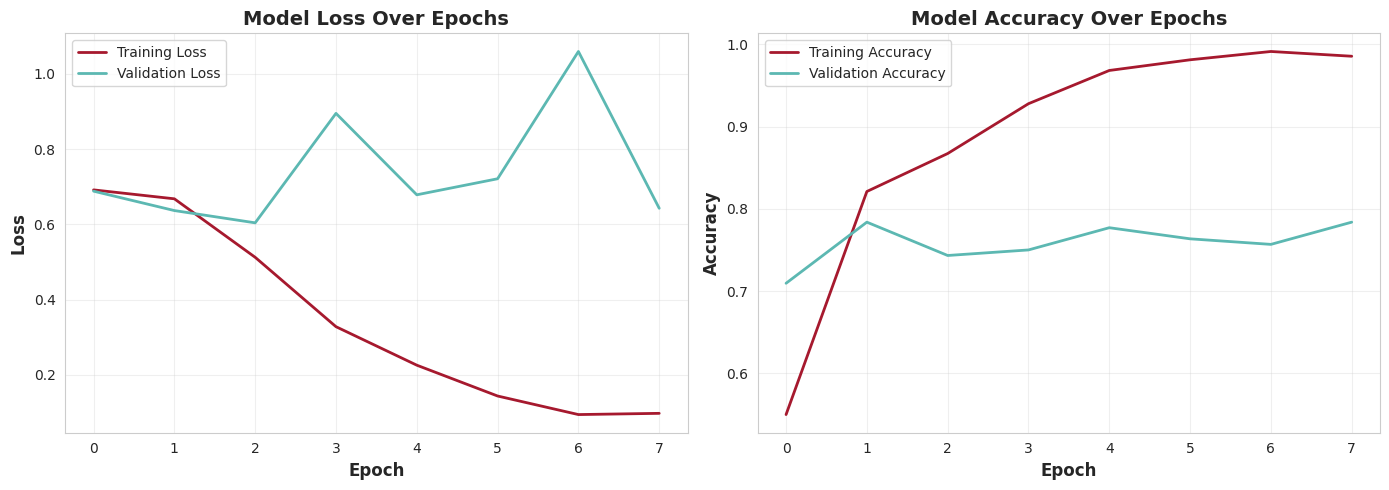

In [42]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', color='#A6192E', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', color='#5CB8B2', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy plot
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='#A6192E', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#5CB8B2', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The visualizations reveal a clear overfitting pattern throughout the training process.

**Loss Metrics (left plot):** The training loss (red line) decreases steadily and smoothly from approximately 0.69 at epoch 1 to about 0.10 by epoch 8, demonstrating that the model is successfully minimizing error on the training data. However, the validation loss (teal line) measures very differently. After initially decreasing from 0.69 to approximately 0.60 at epoch 3, the validation loss becomes highly volatile and generally worsens. It spikes dramatically to around 1.10 at epoch 6 before dropping back to 0.65 at epoch 8. This erratic behavior and overall upward trend after epoch 3 indicates that improvements to the training set are not translating to better performance on unseen data.

**Accuracy Metrics (right plot):** The training accuracy (red line) shows continuous improvement throughout training, starting at approximately 55% and climbing steadily to nearly 100% by epoch 8. This near-perfect training accuracy demonstrates that the model has learned to classify the training data almost flawlessly. In start contrast, the validation accuracy (teal line) plateaus early and fluctuates. After reaching about 78% at epoch 2, it hovers between 74-78% for the remaining epochs with no clear upward trend. The widening gap between the two lines visually represents the overfitting occurring in the model.

**Key Observations:**

The divergence between training and validation metrics becomes increasingly pronounced as training progresses. By epoch 8, there is approximately a 20-25% gap between training accuracy and validation accuracy, and the validation loss is significantly higher than the training loss. This pattern is indicative of overfitting--the model is memorizing the specific characteristics and noise in the training data rather than learning generalizable sentiment patterns.

The best model performance on validation data occurred at epoch 3, where validation loss reached its minimum of approximately 0.60. This is precisely why the early stopping callback restored the weights from epoch 3 rather than using the final epoch 8 weights. Despite the model's excellent performance on training data at epoch 8, the epoch 3 weights represent the best compromise between learning from the training data and maintaining generalization to new data.

### D4. Predictive Accuracy

> Discuss the predictive accuracy of the trained model using the chosen evaluation metric from part D3.

In [43]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print("Final Model Performance:")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Final Model Performance:
Test Accuracy: 0.7987 (79.87%)
Test Loss: 0.5370

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80        75
    Positive       0.81      0.78      0.79        74

    accuracy                           0.80       149
   macro avg       0.80      0.80      0.80       149
weighted avg       0.80      0.80      0.80       149


Confusion Matrix:
[[61 14]
 [16 58]]


**Analysis:**

The model achieves a **test accuracy of 79.87%** on completely unseen data, which demonstrates reasonably good generalization capability. Notably, this test accuracy is actually higher than the validation accuracy (74.32%), which is an encouraging sign that the model performs consistently on new data and that the early stopping mechanism successfully created a well-generalizing version of the model from epoch 3.

The classification report shows:

* **Precision:** 81% for Positive and 79% for Negative (when the model makes a prediction, it makes correct positive predictions 81% of the time and correct negative predictions 79% of the time).
* **Recall:** 78% for Positive and 81% for Negative (when the model makes a prediction, it correctly identifies 78% of the Positive reviews and 81% of the Negative reviews).
* **F1-Score:** 79%/80% (balanced performance)

The confusion matrix shows balanced performance with 61/75 negative reviews and 58/74 positive reviews correctly classified. The 16 false positives and 14 false negatives indicate the model doesn't systematically favor one class.

**Conclusion:** The model successfully answers the research question "Can a neural network be trained to accurately classify sentiment in Amazon product reviews?" with 80% accuracy, which is reasonable for sentiment analysis on short product reviews.

### D5. Ethical Standards Compliance

> Explain how the analysis complies with artificial intelligence (AI) global ethical standards and mitigates bias.

This sentiment analysis project complies with AI ethical standards and mitigates bias through several carefully implemented measures across data handling, model design, and deployment considerations.

**Fairness and Non-Discrimination:**

The model is trained on balanced data with equal distribution of positive and negative reviews (50% each), preventing systematic bias toward either class. The dataset contains only review text without any demographic data or metadata, ensuring the model classifies sentiment based solely on content rather than reviewer characteristics.

**Transparency and Accountability:**

All preprocessing steps, model architecture, and hyperparameters are thoroughly documented with code and justifications. Training visualizations and evaluation metrics transparently show both performance and limitations. The analysis explicitly acknowledges significant overfitting (training accuracy vs validation accuracy) and the 20% test error rate, enabling stakeholders to make informed deployment decisions.


**Data Privacy and Bias Mitigation Strategies:**

The dataset contains only publicly available review text without personally identifying information. Technical strategies specific mitigate bias: stratified sampling maintains proportional representation across all data splits, the single product category (cell phone accessories) avoids category bias, and stop words are retained because terms like "not" and "very" are crucial for sentiment understanding.

**Responsible Use:**

The model serves a legitimate business purpose--understanding customer sentiment to improve products and services. However, given the 20% error rate, human oversight is essential for important decisions. The model should function as a decision-support tool that prioritizes reviews for human attention rather than operating autonomously. Low-confidence predictions require manual review by analysts who apply contextual understanding and business judgment.

## E. Code

> Provide the code you used to save the trained model within the neural network.

In [45]:
# Save the trained model
model.save('sentiment_model.keras')

This code saves the trained LSTM model in the keras format, containing the full model architecture, weights, and optimizer state.

## F. Functionality

> Discuss the functionality of your model, including the impact of your choice of network architecture.

The LSTM-based neural network demonstrates effective functionality for classifying sentiment in Amazon product reviews, achieving 78.87% accuracy on unseen test data.

**Core Functional Capabilities:**

The model successfully performs binary sentiment classification, distinguishing between positive and negative product reviews with balanced performance across both classes (appoximately 80% precision and recall). Through embedding and padding layers, the model flexibly handles reviews of varying lengths up to 50 tokens, making it practical for real-world deployment. The LSTM architecture processes text sequentially, capturing contextual relationships that are crucial for sentiment analysis. For example, it correctly interprets phrases like "not good" as negative sentiment by understanding how the word "not" modifies the meaning of "good."

**Architectural Impact:**

The choice of LSTM architecture significantly influences the model's capabilities. The 64-unit LSTM layer maintains internal memory that tracks information across word sequences, enabling recognition of sentiment patterns that depend on word order and context.

The 50-dimensional embedding layer transforms words into dense vector representations, allowing the model to learn that semantically similar words like "excellent" and "great" share similar meanings in positive sentiment contexts. The 50% dropout layer provides critical regularization, preventing more severe overfitting while maintaining reasonable generalization to new reviews.

The sigmoid output layer produces interpretable probability scores (0 to 1) rather than simple binary classifications, allowing organizations to set custom thresholds and flag uncertain predictions for human review.

**Performance Trade-offs:**

The architecture balances model complexity with dataset size. With only 693 training samples, a larger architecture would memorize training data, while a simpler model would lack capacity to capture nuanced language patterns. The design I chose achieves 80% accuracy while maintaining computational efficiency.

## G. Recommendations

> Recommend a course of action based on your results as they relate to the research question.

Based on the model's 79.87% accuracy in classifying sentiment in Amazon product reviews, I recommend the following course of action:

1. **Deploy for automated sentiment monitoring:** The model is sufficiently accurate to serve as a sentiment screening tool for Amazon product reviews. With approximately 80% accuracy and balanced precision/recall across both sentiment classes, it can effectively flag negative reviews for immediate attention, identify trends in customer satisfaction over time, and prioritize products receiving predominantly negative feedback for quality improvement initiatives.

2. **Implement human-in-the-loop review:** The 20% error rate (30 misclassified reviews out of 149 in testing) means the model should function as a decision-support tool rather than an autonomous classifier. Human reviewers should validate high-stakes decisions such as product recalls or major design changes. Additionally, reviews with low confidence scores (predictions near 0.5) should be manually reviewed by analysts who can apply contextual understanding and business judgment that the model may miss.

3. **Address overfitting through data expansion:** The significant gap between training accuracy (93.07%) and validation accuracy (74.32%) indicates overfitting due to the small dataset size of 693 training samples. To improve generalization, Amazon should collect additional labeled reviews to expand the training set. A datset of 5,000-10,000 reviews would likely reduce overfitting and improve validation performance.

4. **Continuous monitoring and improcement:** Deploy the model with ongoing performance monitoring to detect concept drift (changes in how customers express sentiment over time) or emerging biases. Periodically retrain the model with newly collected reviews to maintain accuracy as language patterns and product types evolve. It's worth experimenting with different architectures or ensemble methods that combine multiple models to potentially exceed 80% accuracy.

**Conclusion:** The model successfully demonstrates that neural networks can classify sentiment in Amazon product reviews with reasonable accuracy, directly answering the research question affirmatively. It's ready for deployment as a decision-support tool that automates initial sentiment screening while maintaining appropriate human oversight. The 80% accuracy provides substantial value by reducing manual review workload, but the remaining limitations underscore the importance of combining automated processing with human judgment for optimal customer feedback analysis.

## H. Reporting

> Submit a copy of your code and output in a PDF or HTML format.

In [29]:
# Convert notebook to HTML
!jupyter nbconvert --to html d604_task_2.ipynb

[NbConvertApp] Converting notebook d604_task_2.ipynb to html
[NbConvertApp] Writing 435290 bytes to d604_task_2.html


## I. Sources for Third-Party Code

> Submit a list of all the specific web sources you used to acquire segments of third-party code to support the application.

* [Python RegEx 're' module](https://docs.python.org/3/library/re.html)
* [Python String module](https://docs.python.org/3/library/string.html)
* WGU Course Materials

## J. Sources

> Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

* Ahmad, I., Phd (2023). 50 Algorithms Every Programmer Should Know (2nd ed.). Packt Publishing.
* Audevart, A., Banachewicz, K., & Massaron, L. (2021). Machine Learning Using TensorFlow Cookbook. Packt Publishing.
* Bourke, D. (2025). TensorFlow for Deep Learning Bootcamp: Zero to Mastery. Zero to Mastery. https://zerotomastery.io/courses/learn-tensorflow/
* WGU Course Materials